In [1]:
!pip install -U tensorflow_addons --quiet

In [2]:
# Standard Libraries
from collections import namedtuple
import itertools
import warnings
warnings.filterwarnings("ignore")

# Anaconda
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns

# TensorFlow
import tensorflow as tf
import tensorflow_addons as tfa

In [3]:
# Definition used for hyperparameter tuning
HP_FACTOR = namedtuple("HP_FACTOR", ["name", "values"])

### Initial EDA and Feature Engineering

In [4]:
# Load data
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv")
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [5]:
# Display the number of fields in each column
df.count()

Date                    10129
Time                    10129
S1_Temp                 10129
S2_Temp                 10129
S3_Temp                 10129
S4_Temp                 10129
S1_Light                10129
S2_Light                10129
S3_Light                10129
S4_Light                10129
S1_Sound                10129
S2_Sound                10129
S3_Sound                10129
S4_Sound                10129
S5_CO2                  10129
S5_CO2_Slope            10129
S6_PIR                  10129
S7_PIR                  10129
Room_Occupancy_Count    10129
dtype: int64

In [6]:
# Identify the type of each column
df.dtypes

Date                     object
Time                     object
S1_Temp                 float64
S2_Temp                 float64
S3_Temp                 float64
S4_Temp                 float64
S1_Light                  int64
S2_Light                  int64
S3_Light                  int64
S4_Light                  int64
S1_Sound                float64
S2_Sound                float64
S3_Sound                float64
S4_Sound                float64
S5_CO2                    int64
S5_CO2_Slope            float64
S6_PIR                    int64
S7_PIR                    int64
Room_Occupancy_Count      int64
dtype: object

In [7]:
# Identify whether the data has any missing values
df.isna().sum()

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64

In [8]:
# Create a more user-friendly "Timestamp" feature from "Date" and "Time" columns
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")
df.insert(0, "Timestamp", timestamp)

In [9]:
# General statistics of the data
df.describe()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
count,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.00000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000,10129.000000
mean,25.454012,25.546059,25.056621,25.754125,25.445059,26.01629,34.248494,13.220259,0.168178,0.120066,0.158119,0.103840,460.860401,-0.004830,0.090137,0.079574,0.398559
std,0.351351,0.586325,0.427283,0.356434,51.011264,67.30417,58.400744,19.602219,0.316709,0.266503,0.413637,0.120683,199.964940,1.164990,0.286392,0.270645,0.893633
min,24.940000,24.750000,24.440000,24.940000,0.000000,0.00000,0.000000,0.000000,0.060000,0.040000,0.040000,0.050000,345.000000,-6.296154,0.000000,0.000000,0.000000
25%,25.190000,25.190000,24.690000,25.440000,0.000000,0.00000,0.000000,0.000000,0.070000,0.050000,0.060000,0.060000,355.000000,-0.046154,0.000000,0.000000,0.000000
50%,25.380000,25.380000,24.940000,25.750000,0.000000,0.00000,0.000000,0.000000,0.080000,0.050000,0.060000,0.080000,360.000000,0.000000,0.000000,0.000000,0.000000
75%,25.630000,25.630000,25.380000,26.000000,12.000000,14.00000,50.000000,22.000000,0.080000,0.060000,0.070000,0.100000,465.000000,0.000000,0.000000,0.000000,0.000000
max,26.380000,29.000000,26.190000,26.560000,165.000000,258.00000,280.000000,74.000000,3.880000,3.440000,3.670000,3.400000,1270.000000,8.980769,1.000000,1.000000,3.000000


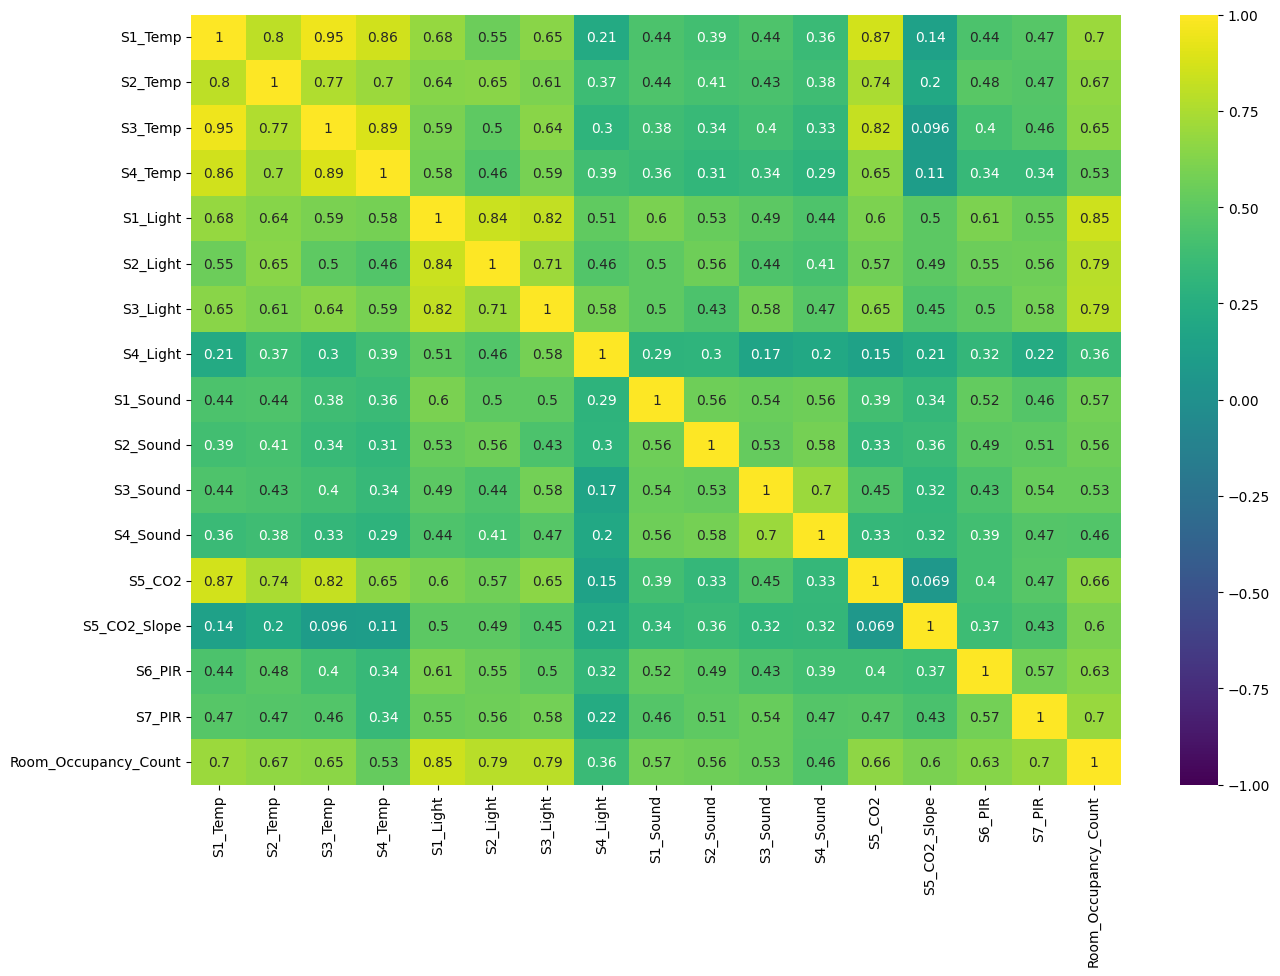

In [10]:
# Correlation of all the columns in the dataframe
fig, ax = plt.subplots(figsize=(15, 10))

sns.heatmap(data=df.corr(), vmin=-1, vmax=1, cmap="viridis", annot=True, ax=ax)
plt.show()

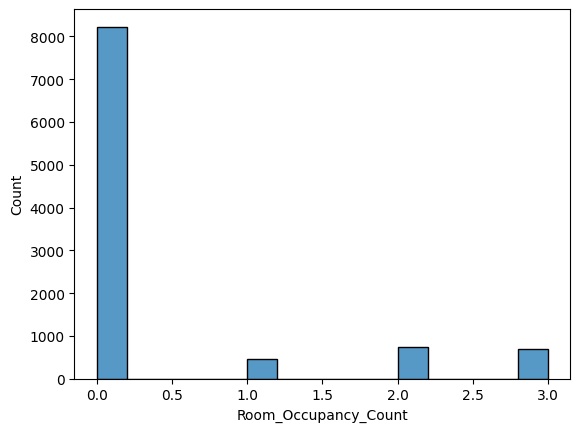

In [11]:
# Explore the distribution of classes
sns.histplot(df["Room_Occupancy_Count"])
plt.show()

In [12]:
# Explore the details of when rooms are empty/occupied
min_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.max()

min_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.min()
max_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.max()

print(f"Min/Max Occupied Time: {min_occupied_time}/{max_occupied_time}")
print(f"Min/Max Unoccupied Time: {min_unoccupied_time}/{max_unoccupied_time}")

Min/Max Occupied Time: 10:49:41/19:51:46
Min/Max Unoccupied Time: 00:00:28/23:59:58


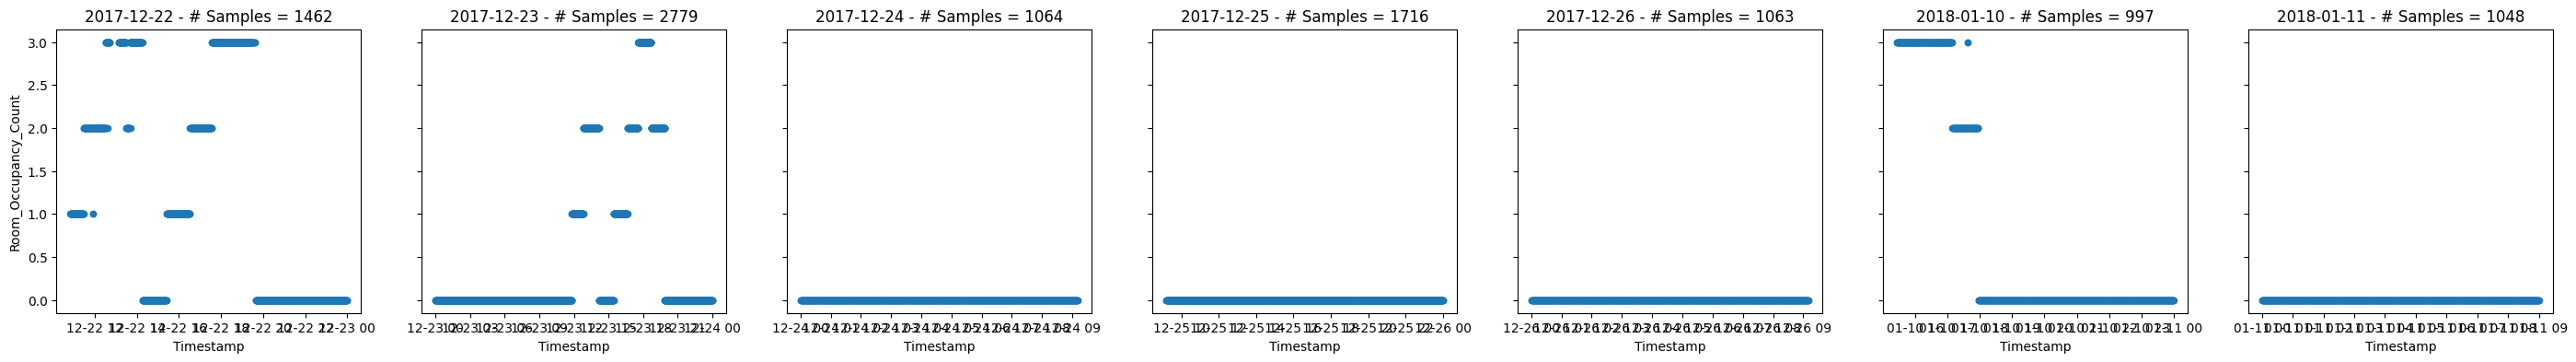

In [13]:
# Visualize when rooms are empty/occupied
fig, axes = plt.subplots(1, df["Timestamp"].dt.date.nunique(), sharey=True, figsize=(35, 4))

for date, ax in zip(df["Timestamp"].dt.date.unique(), axes):
    subset = df[df["Timestamp"].dt.date == date]
    subset.plot(x="Timestamp", y="Room_Occupancy_Count", kind="scatter", ax=ax)
    ax.set_title(f"{date} - # Samples = {len(subset)}")
plt.show()

# Pipeline

### Define Functions

In [14]:
def split_data(X, y, split=(0.6, 0.2, 0.2), random_seed=888):
    """
    Splits X/y into training, validation, and testing sets based on the
    specified split.

    Parameters
    ----------
    X : np.ndarray
        An array-like collection of sample points
    y : np.ndarray
        The class labels of the data, should match the length of data
    split : tuple
        The percentage allocation of training, validation, and test datasets
        Default: (0.6, 0.2, 0.2)
    random_seed : int
        The seed for the random number generator
        Default: 888

    Returns
    -------
    splits : tuple
        The training, validation, and test datasets with their labels
    """
    # Input checking
    if len(X) != len(y):
        raise ValueError(f"X and y lengths don't match ({len(X)} != {len(y)})")
    if len(split) != 3:
        raise ValueError("Invalid split, expected 3 percentages (training, validation, test)")
    if sum(split) != 1:
        raise ValueError(f"Invalid split {split}, percentages must sum to 1!")
    if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
        raise TypeError("X and y must be numpy arrays")

    # Initial split for testing data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=split[2], random_state=random_seed, stratify=y
    )

    # Further split for validation data
    val_size = split[1] / (1 - split[2])
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, random_state=random_seed, stratify=y_train
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [15]:
def calculate_f1_scores(true_labels, predicted_labels, labels=[0, 1, 2, 3], print_output=True):
    """
    Calculates the macro average f1-score, micro average f1-score, and weighted
    average f1-score from the given true and predicted labels

    Parameters
    ----------
    true_labels : np.ndarray
        An array-like collection of the true labels a model is trying to predict
    predicted_labels : np.ndarray
        An array-like collection of the predicted labels output from a model
    labels : list
        The set of unique class labels in the given classification problem
        Default: [0, 1, 2, 3]
    print_output : bool
        Whether to print the metrics out or not
        Default : True

    Returns
    -------
    macro_avg_f1 : float
        The macro average f1-score for the model. The function calculates the f1-score
        for each class individually and takes the unweighted mean of all values    
    micro_avg_f1 : float
        The micro average f1-score for the model. The function considers the total
        True Negatives (TN) and total False Positives (FP) amongst all classes and
        calculates the f1-score globally for the model
    weighted_avg_f1: float
        The support weighted average f1-score for the model. The function calculates
        the f1-score for each class individually and takes the weighted mean of all
        values based on the support of each class
    """

    # Calculate metrics
    macro_avg_f1 = f1_score(true_labels, predicted_labels, labels=labels, average="macro")
    micro_avg_f1 = f1_score(true_labels, predicted_labels, labels=labels, average="micro")
    weighted_avg_f1 = f1_score(true_labels, predicted_labels, labels=labels, average="weighted")

    # Print metrics
    if print_output:
        print("F1-Scores")
        print("---------")
        print(f"Macro average: {macro_avg_f1:9.4f}")
        print(f"Micro average: {micro_avg_f1:9.4f}")
        print(f"Weighted average: {weighted_avg_f1:.4f}\n")

    return macro_avg_f1, micro_avg_f1, weighted_avg_f1

### Load and Prepare Data

In [16]:
# Load data
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv")

# Combine "Date" and "Time" columns into a single timestamp
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")
df.insert(0, "Timestamp", timestamp)
df.drop(columns=["Date", "Time"], inplace=True)

# Save feature and target names
features = df.columns[:-1]
labels = df.columns[-1]

# Convert dataframe into numpy arrays of data
X = df[features].values
y = df[labels].values

# Train/validation/test split
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

# Downsample to time windows where rooms are occupied due to class imbalance
min_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.max()

mask_func = np.vectorize(lambda x: (x.time() > min_occupied_time) & (x.time() < max_occupied_time))
mask = mask_func(X_train[:, 0])

X_train = X_train[mask]
y_train = y_train[mask]

# Downsampling done, no longer need "Timestamp" feature 
X_train = X_train[:, 1:]
X_val = X_val[:, 1:]
X_test = X_test[:, 1:]

# Standardize data
std_scaler = StandardScaler()

X_train_std = std_scaler.fit(X_train).transform(X_train)
X_val_std = std_scaler.fit(X_train).transform(X_val)
X_test_std = std_scaler.fit(X_train).transform(X_test)

### EDA

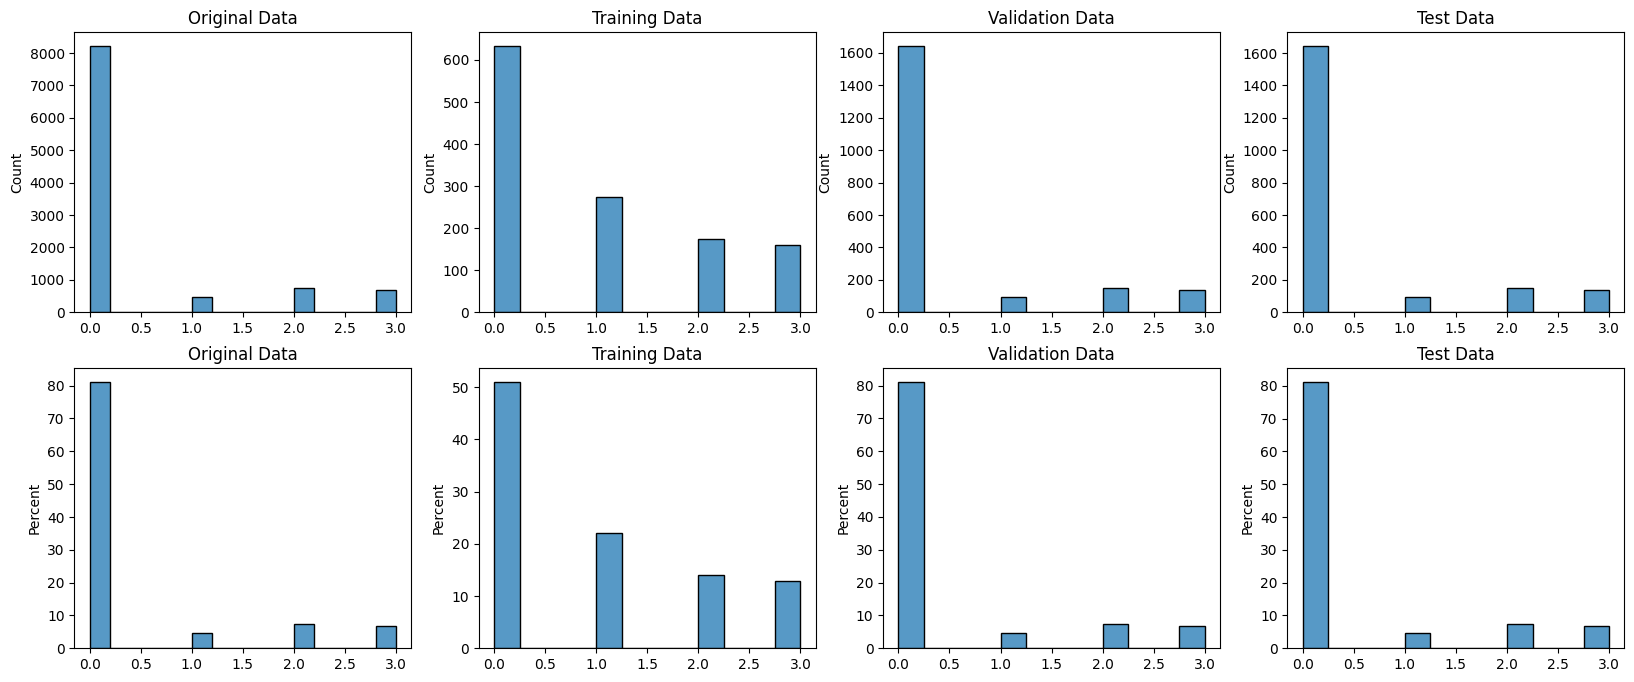

Length of original dataset: 10129

Length of X_train/y_train: 1242/1242
Length of X_val/y_train: 2026/2026
Length of X_test/y_train: 2026/2026

Resulting split: (0.12, 0.20, 0.20)


In [17]:
# Plot showing final distribution of data by class
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

sns.histplot(df[labels], ax=axes[0, 0])
sns.histplot(y_train, ax=axes[0, 1])
sns.histplot(y_val, ax=axes[0, 2])
sns.histplot(y_test, ax=axes[0, 3])

sns.histplot(df[labels], stat="percent", ax=axes[1, 0])
sns.histplot(y_train, stat="percent", ax=axes[1, 1])
sns.histplot(y_val, stat="percent", ax=axes[1, 2])
sns.histplot(y_test, stat="percent", ax=axes[1, 3])

for ax, label in zip(axes[0], ["Original Data", "Training Data", "Validation Data", "Test Data"]):
    ax.set_title(label)
for ax, label in zip(axes[1], ["Original Data", "Training Data", "Validation Data", "Test Data"]):
    ax.set_title(label)

for ax in axes.flatten():
    ax.set_xlabel("")

plt.show()

print(f"Length of original dataset: {len(X)}")
print()
print(f"Length of X_train/y_train: {len(X_train)}/{len(y_train)}")
print(f"Length of X_val/y_train: {len(X_val)}/{len(y_val)}")
print(f"Length of X_test/y_train: {len(X_test)}/{len(y_test)}")
print()
print(f"Resulting split: ({len(X_train)/len(X):.2f}, {len(X_val)/len(X):.2f}, {len(X_test)/len(X):.2f})")

### Baseline Model

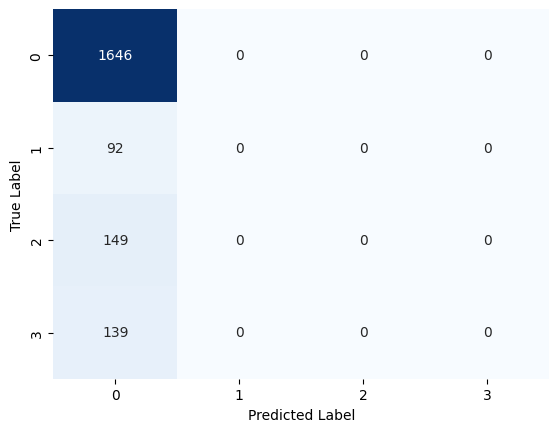

F1-Scores
---------
Macro average:    0.2241
Micro average:    0.8124
Weighted average: 0.7284



In [18]:
# Baseline model always predicts Room_Occupancy_Count == 0
baseline_pred = np.zeros(y_test.shape)

# Display results
sns.heatmap(confusion_matrix(y_test, baseline_pred), annot=True, fmt="g", cmap="Blues", cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

f1_scores = calculate_f1_scores(y_test, baseline_pred)

### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier

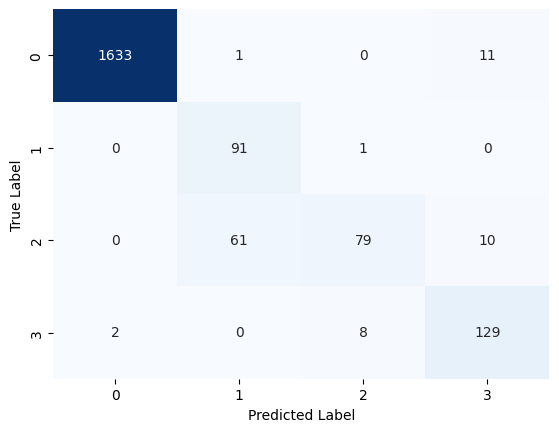

F1-Scores
---------
Macro average:    0.8238
Micro average:    0.9536
Weighted average: 0.9526



In [20]:
# Build and train model
tree = DecisionTreeClassifier(criterion="entropy", random_state=888)
tree.fit(X_train, y_train)

# Make predictions
y_val_pred = tree.predict(X_val)

# Display results
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

f1_scores = calculate_f1_scores(y_val, y_val_pred)

### Logistic Regression

In [21]:
def plot_history(history):
    """
    Plots the training/validation loss for a TensorFlow model

    Parameters
    ----------
    history : pandas DataFrame
        The dataframe of history from the TensorFlow model fit step
    """
    plt.plot(history["loss"], label="Training", marker='o')
    plt.plot(history["val_loss"], label="Validation", marker='o')
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [22]:
def build_logistic_regression(optimizer="Adam", learning_rate=0.001, loss_fn="categorical_crossentropy", random_seed=888):
    """
    Builds a logistic regression model with the hyperparameters specified

    Parameters
    ----------
    optimizer : str
        The string identifier of a TensorFlow optimizer
        Default: "Adam"
    learning_rate : float
        The learning rate for the optimizer
        Default: 0.001
    loss_fn : str
        The string identifier of the TensorFlow loss function
        Default: "categorical_crossentropy"
    random_seed : int
        The seed for the random number generator
        Default: 888

    Returns
    -------
    model : tf.keras.Sequential
        An instantiation of a TensorFlow sequential model representing a logistic regression
    """
    # Initialization
    tf.keras.backend.clear_session()
    tf.random.set_seed(random_seed)

    # Build model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=4, activation="softmax"))

    # Initialize optimizer
    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.lr.assign(learning_rate)

    # Compile model
    model.compile(
        loss=loss_fn,
        optimizer=optimizer, 
        metrics=[
            tfa.metrics.F1Score(num_classes=4, average="macro", name="f1_macro"),
            tfa.metrics.F1Score(num_classes=4, average="micro", name="f1_micro"),
            tfa.metrics.F1Score(num_classes=4, average="weighted", name="f1_weighted")
        ]
    )
    return model

In [23]:
def build_test_logistic_regression(hyper_params, random_seed=888):
    """
    Wrapper of the "build_logistic_regression" function useful for hyperparameter training

    Parameters
    ----------
    hyper_params : dict
        The dictionary containing hyperparameters with "OPTIMIZER", "LEARNING_RATE",
        "LOSS_FN", and "BATCH_SIZE" as keys
    random_seed : int
        The seed for the random number generator
        Default: 888
    
    Returns
    -------
    f1_scores : tuple
        The macro, micro, and weighted average f1-scores of the model with the
        given hyperparameters
    """
    model = build_logistic_regression(
        optimizer=hyper_params["OPTIMIZER"],
        learning_rate=hyper_params["LEARNING_RATE"],
        loss_fn=hyper_params["LOSS_FN"],
        random_seed=random_seed
    )

    model.fit(
        X_train_std,
        tf.one_hot(indices=y_train, depth=4),
        batch_size=hyper_params["BATCH_SIZE"],
        epochs=1000,
        validation_data=(X_val_std, tf.one_hot(indices=y_val, depth=4)),
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)],
        shuffle=True,
        verbose=False
    )

    y_val_pred = np.argmax(model.predict(X_val_std, verbose=1), axis=-1)

    f1_scores = calculate_f1_scores(y_val, y_val_pred, print_output=False)

    return f1_scores

In [24]:
# Define the hyperparameter grid space
OPTIMIZERS = HP_FACTOR("optimizer", ["Adam", "SGD"])
LEARNING_RATES = HP_FACTOR("learning_rate", [0.001, 0.01, 0.1])
LOSS_FNS = HP_FACTOR("loss_fn", ["kullback_leibler_divergence", "categorical_crossentropy"])
BATCH_SIZES = HP_FACTOR("batch_size", [16, 32, 64])

HP_FACTORS = [OPTIMIZERS, LEARNING_RATES, LOSS_FNS, BATCH_SIZES]
HP_NAMES = [factor.name for factor in HP_FACTORS]
HP_VALUES = [factor.values for factor in HP_FACTORS]

# Iterate over all combinations of hyperparameters and store results
hp_matrix = itertools.product(*HP_VALUES)
results = []

for idx, (optimizer, learning_rate, loss_fn, batch_size) in enumerate(hp_matrix):
    hyper_params = {
        "OPTIMIZER": optimizer,
        "LEARNING_RATE": learning_rate,
        "LOSS_FN": loss_fn,
        "BATCH_SIZE": batch_size
    }
    print(f"--- Starting trial: {idx}")
    print(hyper_params)
    macro_f1, micro_f1, weighted_f1 = build_test_logistic_regression(hyper_params)
    results.append([optimizer, learning_rate, loss_fn, batch_size, macro_f1, micro_f1, weighted_f1])

# Build dataframe of results for easy model selection
results = pd.DataFrame(results, columns=HP_NAMES+["macro_f1", "micro_f1", "weighted_f1"])

--- Starting trial: 0
{'OPTIMIZER': 'Adam', 'LEARNING_RATE': 0.001, 'LOSS_FN': 'kullback_leibler_divergence', 'BATCH_SIZE': 16}
64/64 [==============================] - 1s 3ms/step
--- Starting trial: 1
{'OPTIMIZER': 'Adam', 'LEARNING_RATE': 0.001, 'LOSS_FN': 'kullback_leibler_divergence', 'BATCH_SIZE': 32}
64/64 [==============================] - 0s 2ms/step
--- Starting trial: 2
{'OPTIMIZER': 'Adam', 'LEARNING_RATE': 0.001, 'LOSS_FN': 'kullback_leibler_divergence', 'BATCH_SIZE': 64}
64/64 [==============================] - 0s 2ms/step
--- Starting trial: 3
{'OPTIMIZER': 'Adam', 'LEARNING_RATE': 0.001, 'LOSS_FN': 'categorical_crossentropy', 'BATCH_SIZE': 16}
64/64 [==============================] - 0s 1ms/step
--- Starting trial: 4
{'OPTIMIZER': 'Adam', 'LEARNING_RATE': 0.001, 'LOSS_FN': 'categorical_crossentropy', 'BATCH_SIZE': 32}
64/64 [==============================] - 0s 2ms/step
--- Starting trial: 5
{'OPTIMIZER': 'Adam', 'LEARNING_RATE': 0.001, 'LOSS_FN': 'categorical_crossentr

In [25]:
# Identify best model
best_lr_params = results[results.macro_f1.ge(results.macro_f1.max())].iloc[0]
best_lr_params

optimizer                            Adam
learning_rate                        0.01
loss_fn          categorical_crossentropy
batch_size                             32
macro_f1                         0.794533
micro_f1                         0.946693
weighted_f1                      0.941087
Name: 10, dtype: object

Epoch 27: early stopping


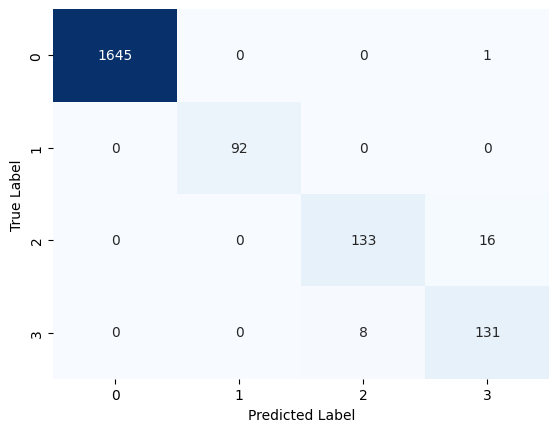

F1-Scores
---------
Macro average:    0.9575
Micro average:    0.9877
Weighted average: 0.9877



In [26]:
# Build and train model using best hyperparameters
model = build_logistic_regression(
    loss_fn=best_lr_params["loss_fn"],
    optimizer=best_lr_params["optimizer"],
    learning_rate=best_lr_params["learning_rate"]
)

history = model.fit(
    np.vstack([X_train_std, X_val_std]),
    tf.one_hot(indices=np.hstack([y_train, y_val]), depth=4),
    batch_size=best_lr_params["batch_size"],
    epochs=1000,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, verbose=1)],
    shuffle=True,
    verbose=False
)

# Make predictions
y_test_pred = np.argmax(model.predict(X_test_std, verbose=0), axis=-1)

# Display results
sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

f1_scores = calculate_f1_scores(y_test, y_test_pred)

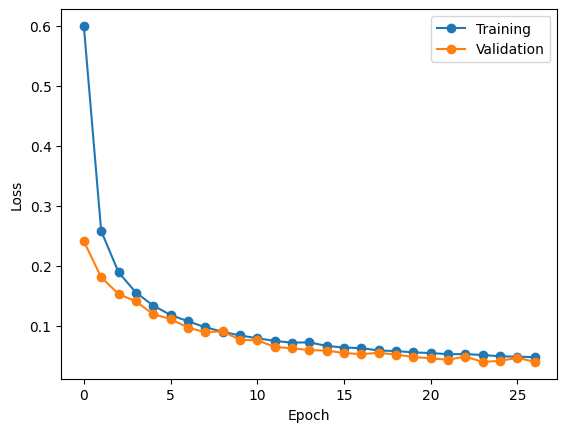

In [27]:
# Display learning curve
history = pd.DataFrame(history.history)
plot_history(history)